In [6]:
#Module for Gillespie's Stochastic Simulation Algorithm
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
class GillespieAlgorithm:
    def __init__(self, forward_rxn_list, backward_rxn_list, \
    rxn_rates, nSpecies, \
    rate_modulation_list = None, cell_divison = None, \
    dosage_compensation = None, growth_dependence = None, \
    replication_time = None, division_time = None, partition_prob = None):
        """
        forward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the output of the
        aforementioned reaction.

        backward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the input of the
        aforementioned reaction.

        rxn_rates: A vector containing the rates for all the reactions.

        rate_modulation_list: A list of lists of size 'number of reactions'.
        For each element in the list, the first half of the elements gives the
        ids of the molecular species which affect the reaction rate for that
        reaction. The magintude of the second half of entries gives the
        magintude by which the molecular species in the corresponding entries
        in the first half affect the reaction rate and the sign tells whether
        the effect is activating (positive) or repressing (negative).

        mol_count_constraints: A list of lists encoding the constraints on the
        additive relationships between the molecular species. If a subset of
        molecular species are constrained such that the sum of their counts is
        constant, then all of these species will be present as a list in one of
        the entries in this variable; the last element gives the constant value
        of the sum. For species which do not adhere to such contraints, the last
        element is -1.

        nSpecies: Number of different molecular species.

        """

        self.rxn_rates = rxn_rates
        self.nSpecies = nSpecies
        self.rate_modulation_list = rate_modulation_list
        self.forward_rxn_list = forward_rxn_list
        array_ = forward_rxn_list[:, 1]
        self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
        self.backward_rxn_list = backward_rxn_list
        self.cell_divison = cell_divison
        self.dosage_compensation = dosage_compensation
        self.growth_dependence = growth_dependence
        self.time_step = None
        self.propensity = [None] * len(self.rxn_rates)
        self.sampled_rxn_id = None
        self.molecule_count = [None] * self.nSpecies
        self.time_list = [None]

    def propensity_count_prod(self, mol_count, rxn_coeff):
        prod_factor = mol_count
        if rxn_coeff - 1 > 0:
            for _ in range(rxn_coeff - 1):
                prod_factor *= mol_count - _ - 1
        return prod_factor

    def calculate_propensity(self, molecule_count):
        for _ in range(len(self.rxn_rates)):
            self.propensity[_] = self.rxn_rates[_] #propensity list for all the reactions
        if self.cell_divison == None and self.dosage_compensation == None and \
        self.growth_dependence == None:
            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 2] != 0:
                    self.propensity[self.backward_rxn_list[_, 1]] *= \
                    self.propensity_count_prod(\
                    molecule_count[self.backward_rxn_list[_, 0]], \
                    self.backward_rxn_list[_, 2])

    def sample_time_step(self):
        a0 = sum(self.propensity)
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def sample_rxn_id(self):
        self.sampled_rxn_id = -1
        a0 = sum(self.propensity)
        r2 = np.random.uniform()
        test = 0
        count = -1
        while test < a0*r2:
            count += 1
            test += self.propensity[count]
        self.sampled_rxn_id = count

    def update_molecule_count(self, molecule_count):
        count_change = [0] * self.nSpecies
        for _ in range((self.forward_rxn_list).shape[0]):
            if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.forward_rxn_list[_, 0]] += \
                self.forward_rxn_list[_, 2]

        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.backward_rxn_list[_, 0]] -= \
                self.backward_rxn_list[_, 2]

        for _ in range(self.nSpecies):
            molecule_count[_] += count_change[_]
        return molecule_count

    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * self.nSpecies
        while sum(time_list) < time_:
#             print('Time = ' + str(sum(time_list)))
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            self.calculate_propensity(molecule_count_cur)
            self.sample_time_step()
            time_list.append(self.time_step)
            self.sample_rxn_id()
            molecule_count_cur = self.update_molecule_count(molecule_count_cur)
            for _ in range(self.nSpecies):
                (molecule_count[_]).append(molecule_count_cur[_])
        self.time_list = time_list
        self.molecule_count = molecule_count


In [56]:
def GillespieParallel(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies, time_ = 100, \
                      molecule_count = [[1]], \
                      rate_modulation_list = None, cell_divison = None, \
                      dosage_compensation = None, growth_dependence = None, \
                      replication_time = None, division_time = None, \
                      partition_prob = None):
    class GillespieAlgorithm:
        def __init__(self, forward_rxn_list, backward_rxn_list, \
                     rxn_rates, nSpecies, \
                     rate_modulation_list = None, cell_divison = None, \
                     dosage_compensation = None, growth_dependence = None, \
                     replication_time = None, division_time = None, partition_prob = None):
            """
            forward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the output of the
            aforementioned reaction.

            backward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the input of the
            aforementioned reaction.

            rxn_rates: A vector containing the rates for all the reactions.

            rate_modulation_list: A list of lists of size 'number of reactions'.
            For each element in the list, the first half of the elements gives the
            ids of the molecular species which affect the reaction rate for that
            reaction. The magintude of the second half of entries gives the
            magintude by which the molecular species in the corresponding entries
            in the first half affect the reaction rate and the sign tells whether
            the effect is activating (positive) or repressing (negative).

            mol_count_constraints: A list of lists encoding the constraints on the
            additive relationships between the molecular species. If a subset of
            molecular species are constrained such that the sum of their counts is
            constant, then all of these species will be present as a list in one of
            the entries in this variable; the last element gives the constant value
            of the sum. For species which do not adhere to such contraints, the last
            element is -1.

            nSpecies: Number of different molecular species.

            """

            self.rxn_rates = rxn_rates
            self.nSpecies = nSpecies
            self.rate_modulation_list = rate_modulation_list
            self.forward_rxn_list = forward_rxn_list
            array_ = forward_rxn_list[:, 1]
            self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
            self.backward_rxn_list = backward_rxn_list
            self.cell_divison = cell_divison
            self.dosage_compensation = dosage_compensation
            self.growth_dependence = growth_dependence
            self.time_step = None
            self.propensity = [None] * len(self.rxn_rates)
            self.sampled_rxn_id = None
            self.molecule_count = [None] * self.nSpecies
            self.time_list = [None]

        def propensity_count_prod(self, mol_count, rxn_coeff):
            prod_factor = mol_count
            if rxn_coeff - 1 > 0:
                for _ in range(rxn_coeff - 1):
                    prod_factor *= mol_count - _ - 1
            return prod_factor

        def calculate_propensity(self, molecule_count):
            for _ in range(len(self.rxn_rates)):
                self.propensity[_] = self.rxn_rates[_] #propensity list for all the reactions
            if self.cell_divison == None and self.dosage_compensation == None and \
            self.growth_dependence == None:
                for _ in range((self.backward_rxn_list).shape[0]):
                    if self.backward_rxn_list[_, 2] != 0:
                        self.propensity[self.backward_rxn_list[_, 1]] *= \
                        self.propensity_count_prod(\
                        molecule_count[self.backward_rxn_list[_, 0]], \
                        self.backward_rxn_list[_, 2])

        def sample_time_step(self):
            a0 = sum(self.propensity)
            r1 = np.random.uniform()
            self.time_step = -np.log(r1)/a0

        def sample_rxn_id(self):
            self.sampled_rxn_id = -1
            a0 = sum(self.propensity)
            r2 = np.random.uniform()
            test = 0
            count = -1
            while test < a0*r2:
                count += 1
                test += self.propensity[count]
            self.sampled_rxn_id = count

        def update_molecule_count(self, molecule_count):
            count_change = [0] * self.nSpecies
            for _ in range((self.forward_rxn_list).shape[0]):
                if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                    count_change[self.forward_rxn_list[_, 0]] += \
                    self.forward_rxn_list[_, 2]

            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                    count_change[self.backward_rxn_list[_, 0]] -= \
                    self.backward_rxn_list[_, 2]

            for _ in range(self.nSpecies):
                molecule_count[_] += count_change[_]
            return molecule_count

        def simulate(self, time_, molecule_count):
            time_list = [0]
            molecule_count_cur = [None] * self.nSpecies
#             print('Time = ' + str(sum(time_list)))
            while sum(time_list) < time_:
#                 print('Time = ' + str(sum(time_list)))
                for _ in range(self.nSpecies):
                    molecule_count_cur[_] = molecule_count[_][-1]
                self.calculate_propensity(molecule_count_cur)
                self.sample_time_step()
                time_list.append(self.time_step)
                self.sample_rxn_id()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(self.nSpecies):
                    (molecule_count[_]).append(molecule_count_cur[_])
            self.time_list = time_list
            self.molecule_count = molecule_count
#     molecule_count = [[1], [0], [10]]
    two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
    two_state.simulate(time_, molecule_count)
    return two_state.time_list, two_state.molecule_count

In [9]:
forward_rxn_list, backward_rxn_list = np.zeros((4, 3), int), np.zeros((4, 3), int)
forward_rxn_list[0, 0] = 0
forward_rxn_list[0, 1] = 0
forward_rxn_list[0, 2] = 1
forward_rxn_list[1, 0] = 0
forward_rxn_list[1, 1] = 2
forward_rxn_list[1, 2] = 1
forward_rxn_list[2, 0] = 1
forward_rxn_list[2, 1] = 1
forward_rxn_list[2, 2] = 1
forward_rxn_list[3, 0] = 2
forward_rxn_list[3, 1] = 0
forward_rxn_list[3, 2] = 1
backward_rxn_list[0, 0] = 0
backward_rxn_list[0, 1] = 0
backward_rxn_list[0, 2] = 1
backward_rxn_list[1, 0] = 0
backward_rxn_list[1, 1] = 1
backward_rxn_list[1, 2] = 1
backward_rxn_list[2, 0] = 1
backward_rxn_list[2, 1] = 2
backward_rxn_list[2, 2] = 1
backward_rxn_list[3, 0] = 2
backward_rxn_list[3, 1] = 3
backward_rxn_list[3, 2] = 1
rxn_rates = [300, 10, 2, 1]
nSpecies = 3

In [4]:
# two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)

In [5]:
#test update_molecule_count
# molecule_count = [1, 0, 10]
# two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.sampled_rxn_id = 3
# molecule_count = two_state.update_molecule_count(molecule_count)
# print(*molecule_count)

In [6]:
#test calculate_propensity
# molecule_count = [0, 1, 10]
# two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.sampled_rxn_id = 0
# print(*(rxn_rates))
# two_state.calculate_propensity(molecule_count)
# print(*(two_state.propensity))
# two_state.sample_time_step()
# two_state.sample_rxn_id()

# print(two_state.time_step)
# print(two_state.sampled_rxn_id)

In [9]:
time_ = 200
molecule_count = [[1], [0], [10]]
two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.calculate_propensity(molecule_count)
# print(*rxn_rates)
# two_state.sampled_rxn_id = 0

two_state.simulate(time_, molecule_count)
print(*rxn_rates)

300 10 2 1


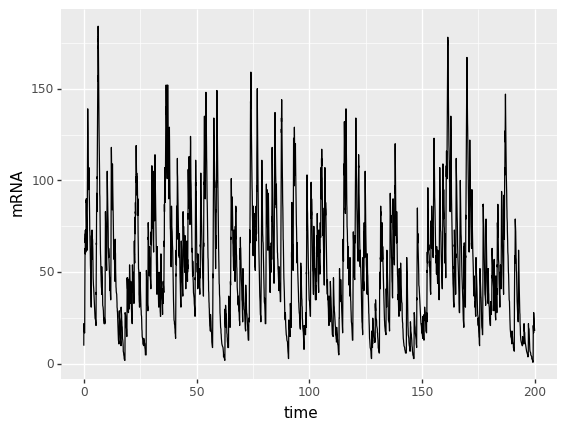

<ggplot: (-9223363266127962715)>


In [10]:
# print(len(two_state.molecule_count[2]))
# print(*(two_state.molecule_count[2][:-1]))
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[2]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [136]:
# print(*(two_state.molecule_count[1][:100]))

In [130]:
random.seed(1234535)
forward_rxn_list, backward_rxn_list = np.zeros((9, 3), int), np.zeros((9, 3), int)
forward_rxn_list[0, 0] = 0
forward_rxn_list[0, 1] = 0
forward_rxn_list[0, 2] = 1
forward_rxn_list[1, 0] = 0
forward_rxn_list[1, 1] = 2
forward_rxn_list[1, 2] = 1
forward_rxn_list[2, 0] = 1
forward_rxn_list[2, 1] = 1
forward_rxn_list[2, 2] = 1
forward_rxn_list[3, 0] = 2
forward_rxn_list[3, 1] = 4
forward_rxn_list[3, 2] = 1
forward_rxn_list[4, 0] = 2
forward_rxn_list[4, 1] = 6
forward_rxn_list[4, 2] = 1
forward_rxn_list[5, 0] = 3
forward_rxn_list[5, 1] = 5
forward_rxn_list[5, 2] = 1
forward_rxn_list[6, 0] = 4
forward_rxn_list[6, 1] = 0
forward_rxn_list[6, 2] = 1
forward_rxn_list[7, 0] = 5
forward_rxn_list[7, 1] = 4
forward_rxn_list[7, 2] = 1
forward_rxn_list[8, 0] = 4
forward_rxn_list[8, 1] = 6
forward_rxn_list[8, 2] = 1
backward_rxn_list[0, 0] = 0
backward_rxn_list[0, 1] = 0
backward_rxn_list[0, 2] = 1
backward_rxn_list[1, 0] = 0
backward_rxn_list[1, 1] = 1
backward_rxn_list[1, 2] = 1
backward_rxn_list[2, 0] = 1
backward_rxn_list[2, 1] = 2
backward_rxn_list[2, 2] = 1
backward_rxn_list[3, 0] = 2
backward_rxn_list[3, 1] = 4
backward_rxn_list[3, 2] = 1
backward_rxn_list[4, 0] = 2
backward_rxn_list[4, 1] = 5
backward_rxn_list[4, 2] = 1
backward_rxn_list[5, 0] = 3
backward_rxn_list[5, 1] = 6
backward_rxn_list[5, 2] = 1
backward_rxn_list[6, 0] = 4
backward_rxn_list[6, 1] = 3
backward_rxn_list[6, 2] = 1
backward_rxn_list[7, 0] = 5
backward_rxn_list[7, 1] = 7
backward_rxn_list[7, 2] = 1
backward_rxn_list[8, 0] = 4
backward_rxn_list[8, 1] = 5
backward_rxn_list[8, 2] = 1
rxn_rates = [300, 10, 2, 1, 300, 1, 2, 1]
nSpecies = 6

In [131]:
time_ = 100
molecule_count = [[1], [0], [0], [1], [10], [5]]
two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.calculate_propensity(molecule_count)
# print(*rxn_rates)
# two_state.sampled_rxn_id = 0

two_state.simulate(time_, molecule_count)

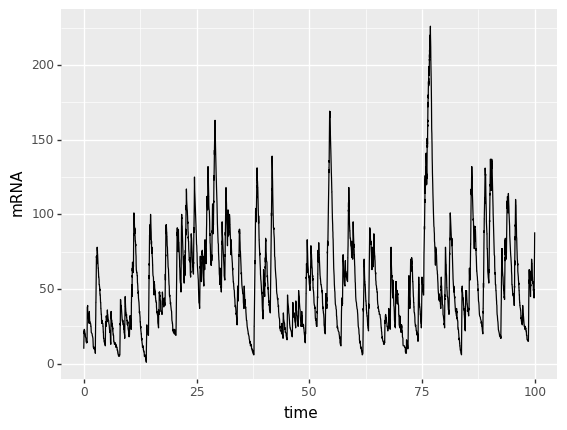

<ggplot: (8746285089407)>


In [132]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[4]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

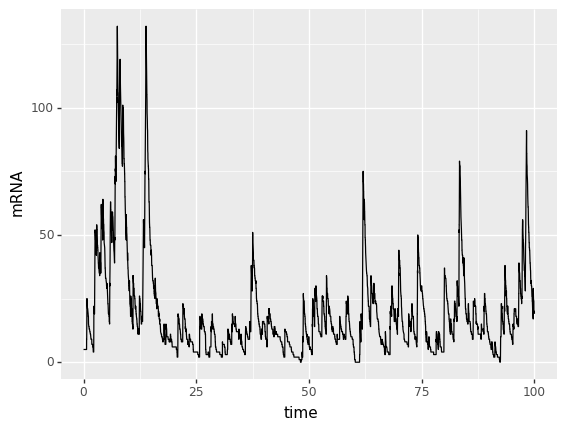

<ggplot: (8746280756463)>


In [133]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[5]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [134]:
time_ = 100
molecule_count = [[1], [0], [0], [1], [10], [5]]
# print(nSpecies)
tmp1, tmp2 = GillespieParallel(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies, time_, molecule_count)

KeyboardInterrupt: 

In [135]:
numCores = 10
time_ = 100
nrepeats = 100
molecule_count = [[1], [0], [0], [1], [10], [5]]
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(GillespieParallel, \
            args=(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies, time_, molecule_count))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()

In [136]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = len(results[_][0])
min_time_steps = np.min(num_time_steps)
print(min_time_steps)

13333.0


In [137]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = len(results[_][0])
min_time_steps = np.min(num_time_steps)
mean_over_time, var_over_time = np.zeros((2, int(min_time_steps))), np.zeros((2, int(min_time_steps)))
for _ in range(int(min_time_steps)):
#     print(_)
    mRNA_t = np.zeros((nrepeats))
    for i in range(nrepeats):
#         print(i)
        mRNA_t[i] = results[i][1][4][_]
    mean_over_time[0, _] = np.mean(mRNA_t)
    var_over_time[0, _] = np.var(mRNA_t)
    
    for i in range(nrepeats):
        mRNA_t[i] = results[i][1][5][_]
    mean_over_time[1, _] = np.mean(mRNA_t)
    var_over_time[1, _] = np.var(mRNA_t)

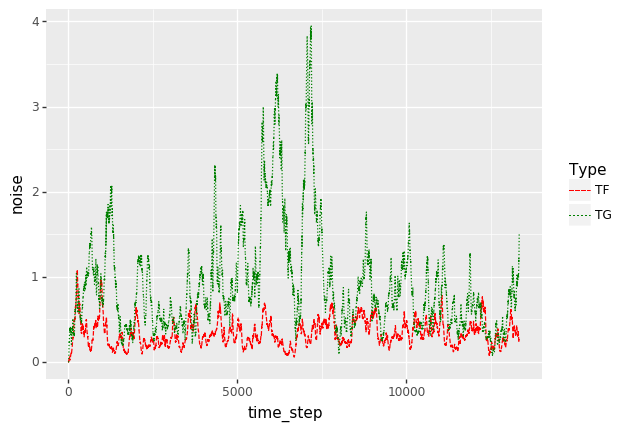

<ggplot: (-9223363290603814568)>


In [140]:
data = {'time_step': (np.arange(min_time_steps)).tolist() * 2, \
       'noise': (np.divide(var_over_time[0, :], np.multiply(mean_over_time[0, :], mean_over_time[0, :]))).tolist() + \
       (1*np.divide(var_over_time[1, :], np.multiply(mean_over_time[1, :], mean_over_time[1, :]))).tolist(), 
       'Type': (['TF'] * int(min_time_steps)) + (['TG'] * int(min_time_steps))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time_step', y='noise')) + geom_line(aes(linetype='Type', color='Type')) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
print(p)

In [121]:
#Activation
forward_rxn_list, backward_rxn_list = np.zeros((9, 3), int), np.zeros((9, 3), int)
forward_rxn_list[0, 0] = 0
forward_rxn_list[0, 1] = 0
forward_rxn_list[0, 2] = 1
forward_rxn_list[1, 0] = 0
forward_rxn_list[1, 1] = 2
forward_rxn_list[1, 2] = 1
forward_rxn_list[2, 0] = 1
forward_rxn_list[2, 1] = 1
forward_rxn_list[2, 2] = 1
forward_rxn_list[3, 0] = 2
forward_rxn_list[3, 1] = 4
forward_rxn_list[3, 2] = 1
forward_rxn_list[4, 0] = 2
forward_rxn_list[4, 1] = 6
forward_rxn_list[4, 2] = 1
forward_rxn_list[5, 0] = 3
forward_rxn_list[5, 1] = 5
forward_rxn_list[5, 2] = 1
forward_rxn_list[6, 0] = 4
forward_rxn_list[6, 1] = 0
forward_rxn_list[6, 2] = 1
forward_rxn_list[7, 0] = 5
forward_rxn_list[7, 1] = 4
forward_rxn_list[7, 2] = 1
forward_rxn_list[8, 0] = 4
forward_rxn_list[8, 1] = 5
forward_rxn_list[8, 2] = 1
backward_rxn_list[0, 0] = 0
backward_rxn_list[0, 1] = 0
backward_rxn_list[0, 2] = 1
backward_rxn_list[1, 0] = 0
backward_rxn_list[1, 1] = 1
backward_rxn_list[1, 2] = 1
backward_rxn_list[2, 0] = 1
backward_rxn_list[2, 1] = 2
backward_rxn_list[2, 2] = 1
backward_rxn_list[3, 0] = 2
backward_rxn_list[3, 1] = 4
backward_rxn_list[3, 2] = 1
backward_rxn_list[4, 0] = 2
backward_rxn_list[4, 1] = 5
backward_rxn_list[4, 2] = 1
backward_rxn_list[5, 0] = 3
backward_rxn_list[5, 1] = 6
backward_rxn_list[5, 2] = 1
backward_rxn_list[6, 0] = 4
backward_rxn_list[6, 1] = 3
backward_rxn_list[6, 2] = 1
backward_rxn_list[7, 0] = 5
backward_rxn_list[7, 1] = 7
backward_rxn_list[7, 2] = 1
backward_rxn_list[8, 0] = 4
backward_rxn_list[8, 1] = 6
backward_rxn_list[8, 2] = 1
rxn_rates = [300, 10, 2, 1, 300, 10, 0.05, 1]
nSpecies = 6

In [122]:
time_ = 100
molecule_count = [[1], [0], [0], [1], [10], [5]]
two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.calculate_propensity(molecule_count)
# print(*rxn_rates)
# two_state.sampled_rxn_id = 0

two_state.simulate(time_, molecule_count)

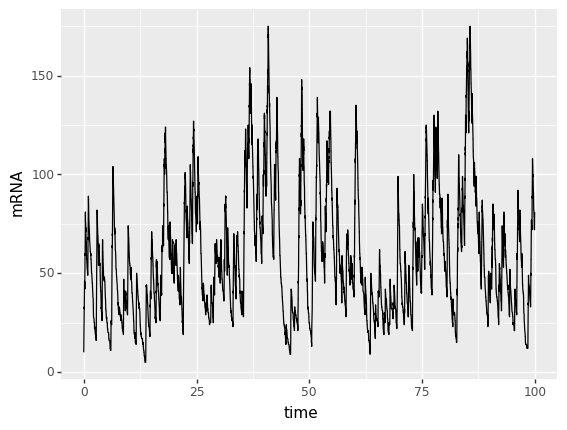

<ggplot: (8746209771696)>


In [123]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[4]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

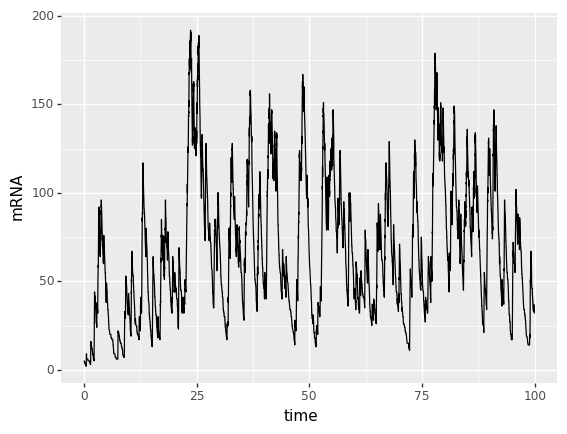

<ggplot: (-9223363290574182084)>


In [124]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[5]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [125]:
numCores = 10
time_ = 100
nrepeats = 100
molecule_count = [[1], [0], [0], [1], [10], [5]]
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(GillespieParallel, \
            args=(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies, time_, molecule_count))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()

In [127]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = len(results[_][0])
min_time_steps = np.min(num_time_steps)
print(min_time_steps)

19189.0


In [128]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = len(results[_][0])
min_time_steps = np.min(num_time_steps)
mean_over_time, var_over_time = np.zeros((2, int(min_time_steps))), np.zeros((2, int(min_time_steps)))
for _ in range(int(min_time_steps)):
#     print(_)
    mRNA_t = np.zeros((nrepeats))
    for i in range(nrepeats):
#         print(i)
        mRNA_t[i] = results[i][1][4][_]
    mean_over_time[0, _] = np.mean(mRNA_t)
    var_over_time[0, _] = np.var(mRNA_t)
    
    for i in range(nrepeats):
        mRNA_t[i] = results[i][1][5][_]
    mean_over_time[1, _] = np.mean(mRNA_t)
    var_over_time[1, _] = np.var(mRNA_t)

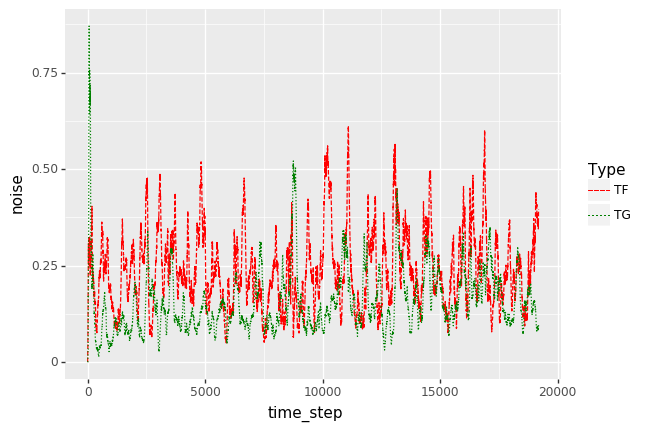

<ggplot: (-9223363290647580384)>


In [129]:
data = {'time_step': (np.arange(min_time_steps)).tolist() * 2, \
       'noise': (np.divide(var_over_time[0, :], np.multiply(mean_over_time[0, :], mean_over_time[0, :]))).tolist() + \
       (0.5*np.divide(var_over_time[1, :], np.multiply(mean_over_time[1, :], mean_over_time[1, :]))).tolist(), 
       'Type': (['TF'] * int(min_time_steps)) + (['TG'] * int(min_time_steps))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time_step', y='noise')) + geom_line(aes(linetype='Type', color='Type')) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
print(p)

In [478]:
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
from scipy.interpolate import interp1d
class GillespieAlgorithmCellCycle:
    def __init__(self, forward_rxn_list, backward_rxn_list, \
    rxn_rates, rxn_rates1, rxn_rates2, nSpecies, kon_which = None, \
    rate_modulation_list = None, growth_dependence = None, \
    replication_time = None, division_time = None, partition_prob = None, \
    dosage_compensation_factor = 1):
        """
        forward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the output of the
        aforementioned reaction.

        backward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the input of the
        aforementioned reaction.

        rxn_rates: A vector containing the rates for all the reactions.

        rate_modulation_list: A list of lists of size 'number of reactions'.
        For each element in the list, the first half of the elements gives the
        ids of the molecular species which affect the reaction rate for that
        reaction. The magintude of the second half of entries gives the
        magintude by which the molecular species in the corresponding entries
        in the first half affect the reaction rate and the sign tells whether
        the effect is activating (positive) or repressing (negative).

        mol_count_constraints: A list of lists encoding the constraints on the
        additive relationships between the molecular species. If a subset of
        molecular species are constrained such that the sum of their counts is
        constant, then all of these species will be present as a list in one of
        the entries in this variable; the last element gives the constant value
        of the sum. For species which do not adhere to such contraints, the last
        element is -1.

        nSpecies: Number of different molecular species.

        """

        self.rxn_rates = rxn_rates
        self.rxn_rates_allele1 = rxn_rates1
        self.rxn_rates_allele2 = rxn_rates2
        self.rxn_rates_daughter1 = [0] * len(rxn_rates)
        self.rxn_rates_daughter2 = [0] * len(rxn_rates)
        self.nSpecies = nSpecies
        self.rate_modulation_list = rate_modulation_list
        self.forward_rxn_list = forward_rxn_list
        array_ = forward_rxn_list[:, 1]
        self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
        self.backward_rxn_list = backward_rxn_list
        self.growth_dependence = growth_dependence
        self.time_step = None
        self.propensity = [None] * (4 * (len(self.rxn_rates) - 2) + 2)
        self.sampled_rxn_id = None
        self.molecule_count = [None] * self.nSpecies
        self.time_list = [None]
        self.replication_time = replication_time
        self.division_time = division_time
        self.partition_prob = partition_prob
        self.kon_which = kon_which
        self.dosage_compensation_factor = dosage_compensation_factor

    def propensity_count_prod(self, mol_count, rxn_coeff):
#         print(rxn_coeff)
        prod_factor = mol_count
        if rxn_coeff - 1 > 0:
            for _ in range(rxn_coeff - 1):
                prod_factor *= mol_count - _ - 1
        return prod_factor

    def calculate_propensity(self, molecule_count):
        for _ in range(len(self.rxn_rates) - 2):
            self.propensity[_] = self.rxn_rates_allele1[_] #propensity list for all the reactions
            self.propensity[_ + len(self.rxn_rates)  - 2] = self.rxn_rates_allele2[_]
            self.propensity[_ + 2 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter1[_] #propensity list for all the reactions
            self.propensity[_ + 3 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter2[_]
        self.propensity[-2] = self.rxn_rates[-2]
        self.propensity[-1] = self.rxn_rates[-1]
        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 2] != 0:
#                 print(type(int(str(molecule_count[self.backward_rxn_list[_, 0]][0]))))
                self.propensity[self.backward_rxn_list[_, 1]] *= \
                self.propensity_count_prod(\
                molecule_count[self.backward_rxn_list[_, 0]], \
                self.backward_rxn_list[_, 2])

    def sample_time_step(self):
        a0 = sum(self.propensity)
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def sample_rxn_id(self):
        self.sampled_rxn_id = -1
        a0 = sum(self.propensity)
        r2 = np.random.uniform()
        test = 0
        count = -1
        while test < a0*r2:
            count += 1
            test += self.propensity[count]
        self.sampled_rxn_id = count

    def update_molecule_count(self, molecule_count):
        count_change = [0] * self.nSpecies
        for _ in range((self.forward_rxn_list).shape[0]):
            if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.forward_rxn_list[_, 0]] += \
                self.forward_rxn_list[_, 2]

        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.backward_rxn_list[_, 0]] -= \
                self.backward_rxn_list[_, 2]

        for _ in range(self.nSpecies):
            molecule_count[_] += count_change[_]
        return molecule_count
    
    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * self.nSpecies
        cycle_num = 0
#         print(self.rxn_rates)
        while sum(time_list) < time_:
#             print('Time = ' + str(rxn_rates[0]))
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            self.calculate_propensity(molecule_count_cur)
            self.sample_time_step()
            if ((sum(time_list) + self.time_step < \
            cycle_num * self.division_time + self.replication_time and \
            sum(time_list) >= cycle_num * self.division_time) or \
            (sum(time_list) + self.time_step < \
            (cycle_num + 1) * self.division_time and \
            sum(time_list) >= \
            cycle_num * self.division_time + self.replication_time)):
                #before replication or before division
                time_list.append(self.time_step)
                self.sample_rxn_id()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(self.nSpecies):
                    (molecule_count[_]).append(molecule_count_cur[_])
            else:
                if sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) + self.time_step > \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) < \
                cycle_num * self.division_time + self.replication_time:
                    #At replication boundary
#                     print("Replication1 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] = self.rxn_rates[self.kon_which]
                    self.rxn_rates_allele2[self.kon_which] = self.rxn_rates[self.kon_which]
#                     print("Replication2 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] *= \
                    self.dosage_compensation_factor
                    self.rxn_rates_allele2[self.kon_which] *= \
                    self.dosage_compensation_factor
#                     print("Replication3 " + str(self.rxn_rates[self.kon_which]))
                    for i in range(len(self.rxn_rates)):
                        self.rxn_rates_daughter1[i] = self.rxn_rates[i]
                        self.rxn_rates_daughter2[i] = self.rxn_rates[i]

                    self.rxn_rates_daughter1[self.kon_which] = 0.0282 * \
                    self.dosage_compensation_factor
                    self.rxn_rates_daughter2[self.kon_which] = 0.0282 * \
                    self.dosage_compensation_factor
                    molecule_count_cur[0] = 0
                    molecule_count_cur[1] = 1
                    molecule_count_cur[2] = 0
                    molecule_count_cur[3] = 1
                    molecule_count_cur[4] = 0
                    molecule_count_cur[5] = 1
                    molecule_count_cur[6] = 0
                    molecule_count_cur[7] = 1
                    time_diff = cycle_num * self.division_time + \
                    self.replication_time - sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    
                    for _ in range(len(self.rxn_rates)):
                        self.rxn_rates_allele1[_] = self.rxn_rates[_]
                        self.rxn_rates_allele2[_] = self.rxn_rates[_]
                        self.rxn_rates_daughter1[_] = 0
                        self.rxn_rates_daughter2[_] = 0
                    mRNA_n = molecule_count_cur[8]
                    mRNA_m = molecule_count_cur[9]
                    molecule_count_cur[8] = 0
                    molecule_count_cur[9] = 0
                    for _ in range(mRNA_n):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[8] += 1
                    for _ in range(mRNA_m):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[9] += 1
                    time_diff = (cycle_num + 1) * self.division_time - \
                    sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                    cycle_num += 1
#         print(self.rxn_rates)
        self.time_list = time_list
        self.molecule_count = molecule_count

def GillespieCellCycleParallel(forward_rxn_list, backward_rxn_list, \
        rxn_rates, rxn_rates1, rxn_rates2, nSpecies, molecule_count, time_, kon_which = None, \
        rate_modulation_list = None, growth_dependence = None, \
        replication_time = None, division_time = None, partition_prob = None, \
        dosage_compensation_factor = 1):
    class GillespieAlgorithmCellCycle:
        def __init__(self, forward_rxn_list, backward_rxn_list, \
        rxn_rates, rxn_rates1, rxn_rates2, nSpecies, kon_which = None, \
        rate_modulation_list = None, growth_dependence = None, \
        replication_time = None, division_time = None, partition_prob = None, \
        dosage_compensation_factor = 1):
            """
            forward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the output of the
            aforementioned reaction.

            backward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the input of the
            aforementioned reaction.

            rxn_rates: A vector containing the rates for all the reactions.

            rate_modulation_list: A list of lists of size 'number of reactions'.
            For each element in the list, the first half of the elements gives the
            ids of the molecular species which affect the reaction rate for that
            reaction. The magintude of the second half of entries gives the
            magintude by which the molecular species in the corresponding entries
            in the first half affect the reaction rate and the sign tells whether
            the effect is activating (positive) or repressing (negative).

            mol_count_constraints: A list of lists encoding the constraints on the
            additive relationships between the molecular species. If a subset of
            molecular species are constrained such that the sum of their counts is
            constant, then all of these species will be present as a list in one of
            the entries in this variable; the last element gives the constant value
            of the sum. For species which do not adhere to such contraints, the last
            element is -1.

            nSpecies: Number of different molecular species.

            """

            self.rxn_rates = rxn_rates
            self.rxn_rates_allele1 = rxn_rates1
            self.rxn_rates_allele2 = rxn_rates2
            self.rxn_rates_daughter1 = [0] * len(rxn_rates)
            self.rxn_rates_daughter2 = [0] * len(rxn_rates)
            self.nSpecies = nSpecies
            self.rate_modulation_list = rate_modulation_list
            self.forward_rxn_list = forward_rxn_list
            array_ = forward_rxn_list[:, 1]
            self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
            self.backward_rxn_list = backward_rxn_list
            self.growth_dependence = growth_dependence
            self.time_step = None
            self.propensity = [None] * (4 * (len(self.rxn_rates) - 2) + 2)
            self.sampled_rxn_id = None
            self.molecule_count = [None] * self.nSpecies
            self.time_list = [None]
            self.replication_time = replication_time
            self.division_time = division_time
            self.partition_prob = partition_prob
            self.kon_which = kon_which
            self.dosage_compensation_factor = dosage_compensation_factor

        def propensity_count_prod(self, mol_count, rxn_coeff):
    #         print(rxn_coeff)
            prod_factor = mol_count
            if rxn_coeff - 1 > 0:
                for _ in range(rxn_coeff - 1):
                    prod_factor *= mol_count - _ - 1
            return prod_factor

        def calculate_propensity(self, molecule_count):
            for _ in range(len(self.rxn_rates) - 2):
                self.propensity[_] = self.rxn_rates_allele1[_] #propensity list for all the reactions
                self.propensity[_ + len(self.rxn_rates)  - 2] = self.rxn_rates_allele2[_]
                self.propensity[_ + 2 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter1[_] #propensity list for all the reactions
                self.propensity[_ + 3 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter2[_]
            self.propensity[-2] = self.rxn_rates[-2]
            self.propensity[-1] = self.rxn_rates[-1]
            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 2] != 0:
    #                 print(type(int(str(molecule_count[self.backward_rxn_list[_, 0]][0]))))
                    self.propensity[self.backward_rxn_list[_, 1]] *= \
                    self.propensity_count_prod(\
                    molecule_count[self.backward_rxn_list[_, 0]], \
                    self.backward_rxn_list[_, 2])

        def sample_time_step(self):
            a0 = sum(self.propensity)
            r1 = np.random.uniform()
            self.time_step = -np.log(r1)/a0

        def sample_rxn_id(self):
            self.sampled_rxn_id = -1
            a0 = sum(self.propensity)
            r2 = np.random.uniform()
            test = 0
            count = -1
            while test < a0*r2:
                count += 1
                test += self.propensity[count]
            self.sampled_rxn_id = count

        def update_molecule_count(self, molecule_count):
            count_change = [0] * self.nSpecies
            for _ in range((self.forward_rxn_list).shape[0]):
                if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                    count_change[self.forward_rxn_list[_, 0]] += \
                    self.forward_rxn_list[_, 2]

            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                    count_change[self.backward_rxn_list[_, 0]] -= \
                    self.backward_rxn_list[_, 2]

            for _ in range(self.nSpecies):
                molecule_count[_] += count_change[_]
            return molecule_count

        def simulate(self, time_, molecule_count):
            time_list = [0]
            molecule_count_cur = [None] * self.nSpecies
            cycle_num = 0
    #         print(self.rxn_rates)
            while sum(time_list) < time_:
    #             print('Time = ' + str(rxn_rates[0]))
                for _ in range(self.nSpecies):
                    molecule_count_cur[_] = molecule_count[_][-1]
                self.calculate_propensity(molecule_count_cur)
                self.sample_time_step()
                if ((sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time) or \
                (sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) >= \
                cycle_num * self.division_time + self.replication_time)):
                    #before replication or before division
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    if sum(time_list) + self.time_step < \
                    (cycle_num + 1) * self.division_time and \
                    sum(time_list) + self.time_step > \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) < \
                    cycle_num * self.division_time + self.replication_time:
                        #At replication boundary
    #                     print("Replication1 " + str(self.rxn_rates[self.kon_which]))
                        self.rxn_rates_allele1[self.kon_which] = self.rxn_rates[self.kon_which]
                        self.rxn_rates_allele2[self.kon_which] = self.rxn_rates[self.kon_which]
    #                     print("Replication2 " + str(self.rxn_rates[self.kon_which]))
                        self.rxn_rates_allele1[self.kon_which] *= \
                        self.dosage_compensation_factor
                        self.rxn_rates_allele2[self.kon_which] *= \
                        self.dosage_compensation_factor
    #                     print("Replication3 " + str(self.rxn_rates[self.kon_which]))
                        for i in range(len(self.rxn_rates)):
                            self.rxn_rates_daughter1[i] = self.rxn_rates[i]
                            self.rxn_rates_daughter2[i] = self.rxn_rates[i]

                        self.rxn_rates_daughter1[self.kon_which] = 0.0282 * \
                        self.dosage_compensation_factor
                        self.rxn_rates_daughter2[self.kon_which] = 0.0282 * \
                        self.dosage_compensation_factor
                        molecule_count_cur[0] = 0
                        molecule_count_cur[1] = 1
                        molecule_count_cur[2] = 0
                        molecule_count_cur[3] = 1
                        molecule_count_cur[4] = 0
                        molecule_count_cur[5] = 1
                        molecule_count_cur[6] = 0
                        molecule_count_cur[7] = 1
                        time_diff = cycle_num * self.division_time + \
                        self.replication_time - sum(time_list)
                        self.calculate_propensity(molecule_count_cur)
                        self.sample_time_step()
                        self.time_step += time_diff
                        time_list.append(self.time_step)
                        self.sample_rxn_id()
                        molecule_count_cur = \
                        self.update_molecule_count(molecule_count_cur)
                        for _ in range(self.nSpecies):
                            (molecule_count[_]).append(molecule_count_cur[_])
                    else:

                        for _ in range(len(self.rxn_rates)):
                            self.rxn_rates_allele1[_] = self.rxn_rates[_]
                            self.rxn_rates_allele2[_] = self.rxn_rates[_]
                            self.rxn_rates_daughter1[_] = 0
                            self.rxn_rates_daughter2[_] = 0
                        mRNA_n = molecule_count_cur[8]
                        mRNA_m = molecule_count_cur[9]
                        molecule_count_cur[8] = 0
                        molecule_count_cur[9] = 0
                        for _ in range(mRNA_n):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[8] += 1
                        for _ in range(mRNA_m):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[9] += 1
                        time_diff = (cycle_num + 1) * self.division_time - \
                        sum(time_list)
                        self.calculate_propensity(molecule_count_cur)
                        self.sample_time_step()
                        self.time_step += time_diff
                        time_list.append(self.time_step)
                        self.sample_rxn_id()
                        molecule_count_cur = \
                        self.update_molecule_count(molecule_count_cur)
                        for _ in range(self.nSpecies):
                            (molecule_count[_]).append(molecule_count_cur[_])
                        cycle_num += 1
#             print(self.rxn_rates)
            self.time_list = time_list
            self.molecule_count = molecule_count
    two_state = GillespieAlgorithmCellCycle(forward_rxn_list, backward_rxn_list, rxn_rates, rxn_rates1, \
                                            rxn_rates2, nSpecies, kon_which = kon_which, \
                                            replication_time = replication_time, division_time = division_time, \
                                            dosage_compensation_factor = dosage_compensation_factor)
    two_state.simulate(time_, molecule_count)
    return two_state.time_list, two_state.molecule_count[8], two_state.molecule_count[9]

In [18]:
#Second trial
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
from scipy.interpolate import interp1d
class GillespieAlgorithmCellCycle:
    def __init__(self, forward_rxn_list, backward_rxn_list, \
    rxn_rates, rxn_rates1, rxn_rates2, nSpecies, kon_which = None, \
    rate_modulation_list = None, growth_dependence = None, \
    replication_time = None, division_time = None, partition_prob = None, \
    dosage_compensation_factor = 1):
        """
        forward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the output of the
        aforementioned reaction.

        backward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the input of the
        aforementioned reaction.

        rxn_rates: A vector containing the rates for all the reactions.

        rate_modulation_list: A list of lists of size 'number of reactions'.
        For each element in the list, the first half of the elements gives the
        ids of the molecular species which affect the reaction rate for that
        reaction. The magintude of the second half of entries gives the
        magintude by which the molecular species in the corresponding entries
        in the first half affect the reaction rate and the sign tells whether
        the effect is activating (positive) or repressing (negative).

        mol_count_constraints: A list of lists encoding the constraints on the
        additive relationships between the molecular species. If a subset of
        molecular species are constrained such that the sum of their counts is
        constant, then all of these species will be present as a list in one of
        the entries in this variable; the last element gives the constant value
        of the sum. For species which do not adhere to such contraints, the last
        element is -1.

        nSpecies: Number of different molecular species.

        """

        self.rxn_rates = rxn_rates
        self.rxn_rates_allele1 = rxn_rates1
        self.rxn_rates_allele2 = rxn_rates2
        self.rxn_rates_daughter1 = [0] * len(rxn_rates)
        self.rxn_rates_daughter2 = [0] * len(rxn_rates)
        self.nSpecies = nSpecies
        self.rate_modulation_list = rate_modulation_list
        self.forward_rxn_list = forward_rxn_list
        array_ = forward_rxn_list[:, 1]
        self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
        self.backward_rxn_list = backward_rxn_list
        self.growth_dependence = growth_dependence
        self.time_step = None
        self.propensity = [None] * (4 * (len(self.rxn_rates) - 2) + 2)
        self.sampled_rxn_id = None
        self.molecule_count = [None] * self.nSpecies
        self.time_list = [None]
        self.replication_time = replication_time
        self.division_time = division_time
        self.partition_prob = partition_prob
        self.kon_which = kon_which
        self.dosage_compensation_factor = dosage_compensation_factor

    def propensity_count_prod(self, mol_count, rxn_coeff):
#         print(rxn_coeff)
        prod_factor = mol_count
        if rxn_coeff - 1 > 0:
            for _ in range(rxn_coeff - 1):
                prod_factor *= mol_count - _ - 1
        return prod_factor

    def calculate_propensity(self, molecule_count):
        for _ in range(len(self.rxn_rates) - 2):
            self.propensity[_] = self.rxn_rates_allele1[_] #propensity list for all the reactions
            self.propensity[_ + len(self.rxn_rates)  - 2] = self.rxn_rates_allele2[_]
            self.propensity[_ + 2 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter1[_] #propensity list for all the reactions
            self.propensity[_ + 3 * (len(self.rxn_rates) - 2)] = self.rxn_rates_daughter2[_]
        self.propensity[-2] = self.rxn_rates[-2]
        self.propensity[-1] = self.rxn_rates[-1]
        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 2] != 0:
#                 print(type(int(str(molecule_count[self.backward_rxn_list[_, 0]][0]))))
                self.propensity[self.backward_rxn_list[_, 1]] *= \
                self.propensity_count_prod(\
                molecule_count[self.backward_rxn_list[_, 0]], \
                self.backward_rxn_list[_, 2])

    def sample_time_step(self):
        a0 = sum(self.propensity)
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def sample_rxn_id(self):
        self.sampled_rxn_id = -1
        a0 = sum(self.propensity)
        r2 = np.random.uniform()
        test = 0
        count = -1
        while test < a0*r2:
            count += 1
            test += self.propensity[count]
        self.sampled_rxn_id = count

    def update_molecule_count(self, molecule_count):
        count_change = [0] * self.nSpecies
        for _ in range((self.forward_rxn_list).shape[0]):
            if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.forward_rxn_list[_, 0]] += \
                self.forward_rxn_list[_, 2]

        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.backward_rxn_list[_, 0]] -= \
                self.backward_rxn_list[_, 2]

        for _ in range(self.nSpecies):
            molecule_count[_] += count_change[_]
        return molecule_count
    
    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * self.nSpecies
        cycle_num = 0
#         print(self.rxn_rates)
        while sum(time_list) < time_:
#             print('Time = ' + str(rxn_rates[0]))
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            self.calculate_propensity(molecule_count_cur)
            self.sample_time_step()
            if ((sum(time_list) + self.time_step < \
            cycle_num * self.division_time + self.replication_time and \
            sum(time_list) >= cycle_num * self.division_time) or \
            (sum(time_list) + self.time_step < \
            (cycle_num + 1) * self.division_time and \
            sum(time_list) >= \
            cycle_num * self.division_time + self.replication_time)):
                #before replication or before division
                time_list.append(self.time_step)
                self.sample_rxn_id()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(self.nSpecies):
                    (molecule_count[_]).append(molecule_count_cur[_])
            else:
                if sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) + self.time_step > \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) < \
                cycle_num * self.division_time + self.replication_time:
                    #At replication boundary
#                     print("Replication1 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] = self.rxn_rates[self.kon_which]
                    self.rxn_rates_allele2[self.kon_which] = self.rxn_rates[self.kon_which]
#                     print("Replication2 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] *= \
                    self.dosage_compensation_factor
                    self.rxn_rates_allele2[self.kon_which] *= \
                    self.dosage_compensation_factor
#                     print("Replication3 " + str(self.rxn_rates[self.kon_which]))
                    for i in range(len(self.rxn_rates)):
                        self.rxn_rates_daughter1[i] = self.rxn_rates[i]
                        self.rxn_rates_daughter2[i] = self.rxn_rates[i]

                    self.rxn_rates_daughter1[self.kon_which] = 0.0282 * \
                    self.dosage_compensation_factor
                    self.rxn_rates_daughter2[self.kon_which] = 0.0282 * \
                    self.dosage_compensation_factor
                    molecule_count_cur[0] = 0
                    molecule_count_cur[1] = 1
                    molecule_count_cur[2] = 0
                    molecule_count_cur[3] = 1
                    molecule_count_cur[4] = 0
                    molecule_count_cur[5] = 1
                    molecule_count_cur[6] = 0
                    molecule_count_cur[7] = 1
                    time_diff = cycle_num * self.division_time + \
                    self.replication_time - sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    
                    for _ in range(len(self.rxn_rates)):
                        self.rxn_rates_allele1[_] = self.rxn_rates[_]
                        self.rxn_rates_allele2[_] = self.rxn_rates[_]
                        self.rxn_rates_daughter1[_] = 0
                        self.rxn_rates_daughter2[_] = 0
                    mRNA_n = molecule_count_cur[8]
                    mRNA_m = molecule_count_cur[9]
                    molecule_count_cur[8] = 0
                    molecule_count_cur[9] = 0
                    for _ in range(mRNA_n):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[8] += 1
                    for _ in range(mRNA_m):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[9] += 1
                    time_diff = (cycle_num + 1) * self.division_time - \
                    sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                    cycle_num += 1
#         print(self.rxn_rates)
        self.time_list = time_list
        self.molecule_count = molecule_count

        
class GillespieAlgorithmCellCycle:
    def __init__(self, forward_rxn_list, backward_rxn_list, \
    rxn_rates, nSpecies, kon_which = None, \
    rate_modulation_list = None, growth_dependence = None, \
    replication_time = None, division_time = None, partition_prob = None, \
    dosage_compensation_factor = 1):
        """
        forward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the output of the
        aforementioned reaction.

        backward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the input of the
        aforementioned reaction.

        rxn_rates: A vector containing the rates for all the reactions.

        rate_modulation_list: A list of lists of size 'number of reactions'.
        For each element in the list, the first half of the elements gives the
        ids of the molecular species which affect the reaction rate for that
        reaction. The magintude of the second half of entries gives the
        magintude by which the molecular species in the corresponding entries
        in the first half affect the reaction rate and the sign tells whether
        the effect is activating (positive) or repressing (negative).

        mol_count_constraints: A list of lists encoding the constraints on the
        additive relationships between the molecular species. If a subset of
        molecular species are constrained such that the sum of their counts is
        constant, then all of these species will be present as a list in one of
        the entries in this variable; the last element gives the constant value
        of the sum. For species which do not adhere to such contraints, the last
        element is -1.

        nSpecies: Number of different molecular species.

        """

        self.rxn_rates = np.copy(rxn_rates)
        self.rxn_rates_allele1 = np.copy(rxn_rates)
        self.rxn_rates_allele2 = np.copy(rxn_rates)
        self.rxn_rates_daughter1 = [0] * len(rxn_rates)
        self.rxn_rates_daughter2 = [0] * len(rxn_rates)
        self.nSpecies = nSpecies
        self.rate_modulation_list = rate_modulation_list
        self.forward_rxn_list = forward_rxn_list
        array_ = forward_rxn_list[:, 1]
        self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
        self.backward_rxn_list = backward_rxn_list
        self.growth_dependence = growth_dependence
        self.time_step = None
        self.propensity = [None] * (4 * (len(self.rxn_rates) - 2) + 2)
        self.sampled_rxn_id = None
        self.molecule_count = [None] * self.nSpecies
        self.time_list = [None]
        self.replication_time = replication_time
        self.division_time = division_time
        self.partition_prob = partition_prob
        self.kon_which = kon_which
        self.dosage_compensation_factor = dosage_compensation_factor

    def propensity_count_prod(self, mol_count, rxn_coeff):
#         print(rxn_coeff)
        prod_factor = mol_count
        if rxn_coeff - 1 > 0:
            for _ in range(rxn_coeff - 1):
                prod_factor *= mol_count - _ - 1
        return prod_factor

    def calculate_propensity(self, molecule_count):
        for _ in range(len(self.rxn_rates) - 2):
            self.propensity[_] = np.copy(self.rxn_rates_allele1[_]) #propensity list for all the reactions
            self.propensity[_ + len(self.rxn_rates)  - 2] = np.copy(self.rxn_rates_allele2[_])
            self.propensity[_ + 2 * (len(self.rxn_rates) - 2)] = \
            np.copy(self.rxn_rates_daughter1[_])#propensity list for all the reactions
            self.propensity[_ + 3 * (len(self.rxn_rates) - 2)] = np.copy(self.rxn_rates_daughter2[_])
        self.propensity[-2] = np.copy(self.rxn_rates[-2])
        self.propensity[-1] = np.copy(self.rxn_rates[-1])
        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 2] != 0:
#                 print(type(int(str(molecule_count[self.backward_rxn_list[_, 0]][0]))))
                id1_ = (np.copy(self.backward_rxn_list[_, 1])).astype(int)
                id0_ = (np.copy(self.backward_rxn_list[_, 0])).astype(int)
                count_ = (np.copy(self.backward_rxn_list[_, 2])).astype(int)
                self.propensity[id1_] *= \
                self.propensity_count_prod(\
                molecule_count[id0_], \
                count_)

    def sample_time_step(self):
        a0 = sum(self.propensity)
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def sample_rxn_id(self):
        self.sampled_rxn_id = -1
        a0 = sum(self.propensity)
        r2 = np.random.uniform()
        test = 0
        count = -1
        while test < a0*r2:
            count += 1
            test += self.propensity[count]
        self.sampled_rxn_id = count

    def update_molecule_count(self, molecule_count):
        count_change = [0] * self.nSpecies
        for _ in range((self.forward_rxn_list).shape[0]):
            if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                id0_ = (np.copy(self.forward_rxn_list[_, 0])).astype(int)
                count_ = (np.copy(self.forward_rxn_list[_, 2])).astype(int)
                count_change[id0_] += \
                count_

        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                id0_ = (np.copy(self.backward_rxn_list[_, 0])).astype(int)
                count_ = (np.copy(self.backward_rxn_list[_, 2])).astype(int)
                count_change[id0_] -= \
                count_

        for _ in range(self.nSpecies):
            molecule_count[_] += count_change[_]
        return molecule_count

    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * self.nSpecies
        cycle_num = 0
#         print(self.rxn_rates)
        while sum(time_list) < time_:
#             print('Time = ' + str(self.rxn_rates[0]))
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            self.calculate_propensity(molecule_count_cur)
            self.sample_time_step()
            if ((sum(time_list) + self.time_step < \
            cycle_num * self.division_time + self.replication_time and \
            sum(time_list) >= cycle_num * self.division_time) or \
            (sum(time_list) + self.time_step < \
            (cycle_num + 1) * self.division_time and \
            sum(time_list) >= \
            cycle_num * self.division_time + self.replication_time)):
                #before replication or before division
                time_list.append(self.time_step)
                self.sample_rxn_id()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(self.nSpecies):
                    (molecule_count[_]).append(molecule_count_cur[_])
            else:
                if sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) + self.time_step > \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) < \
                cycle_num * self.division_time + self.replication_time:
                    #At replication boundary
#                     print("Replication1 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] = np.copy(self.rxn_rates[self.kon_which])
                    self.rxn_rates_allele2[self.kon_which] = np.copy(self.rxn_rates[self.kon_which])
#                     print("Replication2 " + str(self.rxn_rates[self.kon_which]))
                    self.rxn_rates_allele1[self.kon_which] *= \
                    self.dosage_compensation_factor
                    self.rxn_rates_allele2[self.kon_which] *= \
                    self.dosage_compensation_factor
#                     print("Replication3 " + str(self.rxn_rates[self.kon_which]))
                    for i in range(len(self.rxn_rates)):
                        self.rxn_rates_daughter1[i] = np.copy(self.rxn_rates[i])
                        self.rxn_rates_daughter2[i] = np.copy(self.rxn_rates[i])

                    self.rxn_rates_daughter1[self.kon_which] = np.copy(self.rxn_rates[0]) * \
                    self.dosage_compensation_factor
                    self.rxn_rates_daughter2[self.kon_which] = np.copy(self.rxn_rates[0]) * \
                    self.dosage_compensation_factor
                    molecule_count_cur[0] = 0
                    molecule_count_cur[1] = 1
                    molecule_count_cur[2] = 0
                    molecule_count_cur[3] = 1
                    molecule_count_cur[4] = 0
                    molecule_count_cur[5] = 1
                    molecule_count_cur[6] = 0
                    molecule_count_cur[7] = 1
                    time_diff = cycle_num * self.division_time + \
                    self.replication_time - sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                else:

                    for _ in range(len(self.rxn_rates)):
                        self.rxn_rates_allele1[_] = np.copy(self.rxn_rates[_])
                        self.rxn_rates_allele2[_] = np.copy(self.rxn_rates[_])
                        self.rxn_rates_daughter1[_] = 0
                        self.rxn_rates_daughter2[_] = 0
                    mRNA_n = molecule_count_cur[8]
                    mRNA_m = molecule_count_cur[9]
                    molecule_count_cur[8] = 0
                    molecule_count_cur[9] = 0
                    for _ in range(mRNA_n):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[8] += 1
                    for _ in range(mRNA_m):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[9] += 1
                    time_diff = (cycle_num + 1) * self.division_time - \
                    sum(time_list)
                    self.calculate_propensity(molecule_count_cur)
                    self.sample_time_step()
                    self.time_step += time_diff
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = \
                    self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                    cycle_num += 1
#             print(self.rxn_rates)
        self.time_list = time_list
        self.molecule_count = molecule_count

def GillespieCellCycleParallel(forward_rxn_list, backward_rxn_list, \
        rxn_rates, nSpecies, molecule_count, time_, kon_which = None, \
        rate_modulation_list = None, growth_dependence = None, \
        replication_time = None, division_time = None, partition_prob = None, \
        dosage_compensation_factor = 1):
    class GillespieAlgorithmCellCycle:
        def __init__(self, forward_rxn_list, backward_rxn_list, \
        rxn_rates, nSpecies, kon_which = None, \
        rate_modulation_list = None, growth_dependence = None, \
        replication_time = None, division_time = None, partition_prob = None, \
        dosage_compensation_factor = 1):
            """
            forward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the output of the
            aforementioned reaction.

            backward_rxn_list: A three-column matrix where for each row, the first
            entry is the id for a molecular species, the second entry is the
            id for a chemical reaction and the third entry is the coefficient for
            the aforementioned molceular species in the input of the
            aforementioned reaction.

            rxn_rates: A vector containing the rates for all the reactions.

            rate_modulation_list: A list of lists of size 'number of reactions'.
            For each element in the list, the first half of the elements gives the
            ids of the molecular species which affect the reaction rate for that
            reaction. The magintude of the second half of entries gives the
            magintude by which the molecular species in the corresponding entries
            in the first half affect the reaction rate and the sign tells whether
            the effect is activating (positive) or repressing (negative).

            mol_count_constraints: A list of lists encoding the constraints on the
            additive relationships between the molecular species. If a subset of
            molecular species are constrained such that the sum of their counts is
            constant, then all of these species will be present as a list in one of
            the entries in this variable; the last element gives the constant value
            of the sum. For species which do not adhere to such contraints, the last
            element is -1.

            nSpecies: Number of different molecular species.

            """

            self.rxn_rates = np.copy(rxn_rates)
            self.rxn_rates_allele1 = np.copy(rxn_rates)
            self.rxn_rates_allele2 = np.copy(rxn_rates)
            self.rxn_rates_daughter1 = [0] * len(rxn_rates)
            self.rxn_rates_daughter2 = [0] * len(rxn_rates)
            self.nSpecies = nSpecies
            self.rate_modulation_list = rate_modulation_list
            self.forward_rxn_list = forward_rxn_list
            array_ = forward_rxn_list[:, 1]
            self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
            self.backward_rxn_list = backward_rxn_list
            self.growth_dependence = growth_dependence
            self.time_step = None
            self.propensity = [None] * (4 * (len(self.rxn_rates) - 2) + 2)
            self.sampled_rxn_id = None
            self.molecule_count = [None] * self.nSpecies
            self.time_list = [None]
            self.replication_time = replication_time
            self.division_time = division_time
            self.partition_prob = partition_prob
            self.kon_which = kon_which
            self.dosage_compensation_factor = dosage_compensation_factor

        def propensity_count_prod(self, mol_count, rxn_coeff):
    #         print(rxn_coeff)
            prod_factor = mol_count
            if rxn_coeff - 1 > 0:
                for _ in range(rxn_coeff - 1):
                    prod_factor *= mol_count - _ - 1
            return prod_factor

        def calculate_propensity(self, molecule_count):
            for _ in range(len(self.rxn_rates) - 2):
                self.propensity[_] = np.copy(self.rxn_rates_allele1[_]) #propensity list for all the reactions
                self.propensity[_ + len(self.rxn_rates)  - 2] = np.copy(self.rxn_rates_allele2[_])
                self.propensity[_ + 2 * (len(self.rxn_rates) - 2)] = \
                np.copy(self.rxn_rates_daughter1[_])#propensity list for all the reactions
                self.propensity[_ + 3 * (len(self.rxn_rates) - 2)] = np.copy(self.rxn_rates_daughter2[_])
            self.propensity[-2] = np.copy(self.rxn_rates[-2])
            self.propensity[-1] = np.copy(self.rxn_rates[-1])
            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 2] != 0:
    #                 print(type(int(str(molecule_count[self.backward_rxn_list[_, 0]][0]))))
                    id1_ = (np.copy(self.backward_rxn_list[_, 1])).astype(int)
                    id0_ = (np.copy(self.backward_rxn_list[_, 0])).astype(int)
                    count_ = (np.copy(self.backward_rxn_list[_, 2])).astype(int)
                    self.propensity[id1_] *= \
                    self.propensity_count_prod(\
                    molecule_count[id0_], \
                    count_)

        def sample_time_step(self):
            a0 = sum(self.propensity)
            r1 = np.random.uniform()
            self.time_step = -np.log(r1)/a0

        def sample_rxn_id(self):
            self.sampled_rxn_id = -1
            a0 = sum(self.propensity)
            r2 = np.random.uniform()
            test = 0
            count = -1
            while test < a0*r2:
                count += 1
                test += self.propensity[count]
            self.sampled_rxn_id = count

        def update_molecule_count(self, molecule_count):
            count_change = [0] * self.nSpecies
            for _ in range((self.forward_rxn_list).shape[0]):
                if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                    id0_ = (np.copy(self.forward_rxn_list[_, 0])).astype(int)
                    count_ = (np.copy(self.forward_rxn_list[_, 2])).astype(int)
                    count_change[id0_] += \
                    count_

            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                    id0_ = (np.copy(self.backward_rxn_list[_, 0])).astype(int)
                    count_ = (np.copy(self.backward_rxn_list[_, 2])).astype(int)
                    count_change[id0_] -= \
                    count_

            for _ in range(self.nSpecies):
                molecule_count[_] += count_change[_]
            return molecule_count

        def simulate(self, time_, molecule_count):
            time_list = [0]
            molecule_count_cur = [None] * self.nSpecies
            cycle_num = 0
    #         print(self.rxn_rates)
            while sum(time_list) < time_:
    #             print('Time = ' + str(rxn_rates[0]))
                for _ in range(self.nSpecies):
                    molecule_count_cur[_] = molecule_count[_][-1]
                self.calculate_propensity(molecule_count_cur)
                self.sample_time_step()
                if ((sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time) or \
                (sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) >= \
                cycle_num * self.division_time + self.replication_time)):
                    #before replication or before division
                    time_list.append(self.time_step)
                    self.sample_rxn_id()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(self.nSpecies):
                        (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    if sum(time_list) + self.time_step < \
                    (cycle_num + 1) * self.division_time and \
                    sum(time_list) + self.time_step > \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) < \
                    cycle_num * self.division_time + self.replication_time:
                        #At replication boundary
    #                     print("Replication1 " + str(self.rxn_rates[self.kon_which]))
                        self.rxn_rates_allele1[self.kon_which] = np.copy(self.rxn_rates[self.kon_which])
                        self.rxn_rates_allele2[self.kon_which] = np.copy(self.rxn_rates[self.kon_which])
    #                     print("Replication2 " + str(self.rxn_rates[self.kon_which]))
                        self.rxn_rates_allele1[self.kon_which] *= \
                        self.dosage_compensation_factor
                        self.rxn_rates_allele2[self.kon_which] *= \
                        self.dosage_compensation_factor
    #                     print("Replication3 " + str(self.rxn_rates[self.kon_which]))
                        for i in range(len(self.rxn_rates)):
                            self.rxn_rates_daughter1[i] = np.copy(self.rxn_rates[i])
                            self.rxn_rates_daughter2[i] = np.copy(self.rxn_rates[i])

                        self.rxn_rates_daughter1[self.kon_which] = np.copy(self.rxn_rates[0]) * \
                        self.dosage_compensation_factor
                        self.rxn_rates_daughter2[self.kon_which] = np.copy(self.rxn_rates[0]) * \
                        self.dosage_compensation_factor
                        molecule_count_cur[0] = 0
                        molecule_count_cur[1] = 1
                        molecule_count_cur[2] = 0
                        molecule_count_cur[3] = 1
                        molecule_count_cur[4] = 0
                        molecule_count_cur[5] = 1
                        molecule_count_cur[6] = 0
                        molecule_count_cur[7] = 1
                        time_diff = cycle_num * self.division_time + \
                        self.replication_time - sum(time_list)
                        self.calculate_propensity(molecule_count_cur)
                        self.sample_time_step()
                        self.time_step += time_diff
                        time_list.append(self.time_step)
                        self.sample_rxn_id()
                        molecule_count_cur = \
                        self.update_molecule_count(molecule_count_cur)
                        for _ in range(self.nSpecies):
                            (molecule_count[_]).append(molecule_count_cur[_])
                    else:

                        for _ in range(len(self.rxn_rates)):
                            self.rxn_rates_allele1[_] = np.copy(self.rxn_rates[_])
                            self.rxn_rates_allele2[_] = np.copy(self.rxn_rates[_])
                            self.rxn_rates_daughter1[_] = 0
                            self.rxn_rates_daughter2[_] = 0
                        mRNA_n = molecule_count_cur[8]
                        mRNA_m = molecule_count_cur[9]
                        molecule_count_cur[8] = 0
                        molecule_count_cur[9] = 0
                        for _ in range(mRNA_n):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[8] += 1
                        for _ in range(mRNA_m):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[9] += 1
                        time_diff = (cycle_num + 1) * self.division_time - \
                        sum(time_list)
                        self.calculate_propensity(molecule_count_cur)
                        self.sample_time_step()
                        self.time_step += time_diff
                        time_list.append(self.time_step)
                        self.sample_rxn_id()
                        molecule_count_cur = \
                        self.update_molecule_count(molecule_count_cur)
                        for _ in range(self.nSpecies):
                            (molecule_count[_]).append(molecule_count_cur[_])
                        cycle_num += 1
#             print(self.rxn_rates)
            self.time_list = time_list
            self.molecule_count = molecule_count
    two_state = GillespieAlgorithmCellCycle(forward_rxn_list, backward_rxn_list, rxn_rates,\
                                            nSpecies, kon_which = kon_which, \
                                            replication_time = replication_time, division_time = division_time, \
                                            dosage_compensation_factor = dosage_compensation_factor)
    two_state.simulate(time_, molecule_count)
    return two_state.time_list, two_state.molecule_count[8], two_state.molecule_count[9]

In [19]:
forward_rxn_list = np.genfromtxt('/media/atheistpoet/TarunHDD/Python_Workspace/Projects/Buffer/forward_rxn_M5.txt', delimiter=',')
backward_rxn_list = np.genfromtxt('/media/atheistpoet/TarunHDD/Python_Workspace/Projects/Buffer/backward_rxn_M5.txt', delimiter=',')
forward_rxn_list = forward_rxn_list.astype(int)
backward_rxn_list = backward_rxn_list.astype(int)

In [20]:
import numpy as np
a = 1.2
a = int(a)
print(a)

1


In [480]:
# print(backward_rxn_list)

In [510]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
rxn_rates1 = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
rxn_rates2 = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
# rxn_rates = [0.0282, 0.609, 2.11] * 4
# rxn_rates.append(0.1299)
# rxn_rates.append(0.00245)
nSpecies = 10
tr = 400
td = 780
dosage_compensation_factor = 0.71
molecule_count = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]

numCores = 10
time_ = 5000
nrepeats = 5000
molecule_count = [[1], [0], [1], [0], [0], [1], [0], [1], [0], [0]]
kon_which = 0
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(GillespieCellCycleParallel, \
            args=(forward_rxn_list, backward_rxn_list, rxn_rates, rxn_rates1, rxn_rates2,\
                  nSpecies, molecule_count, time_, kon_which, \
                  None, None, tr, td, None, \
                  dosage_compensation_factor))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()


# two_state = GillespieAlgorithmCellCycle(forward_rxn_list, backward_rxn_list, rxn_rates, rxn_rates1, rxn_rates2,\
#                                         nSpecies, kon_which = 0, \
#                                        replication_time = tr, division_time = td, \
#                                         dosage_compensation_factor = dosage_compensation_factor)

In [22]:
# two_state = GillespieAlgorithmCellCycle(forward_rxn_list, backward_rxn_list, rxn_rates,\
#                                         nSpecies, kon_which = 0, \
#                                        replication_time = tr, division_time = td, \
#                                         dosage_compensation_factor = dosage_compensation_factor)
# time_ = 5000
# molecule_count = [[1], [0], [1], [0], [0], [1], [0], [1], [0], [0]]
# two_state.simulate(time_, molecule_count)

In [23]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
# rxn_rates = [0.0282, 0.609, 2.11] * 4
# rxn_rates.append(0.1299)
# rxn_rates.append(0.00245)
nSpecies = 10
tr = 400
td = 780
dosage_compensation_factor = 0.71
molecule_count = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]

numCores = 10
time_ = 5000
nrepeats = 1000
molecule_count = [[1], [0], [1], [0], [0], [1], [0], [1], [0], [0]]
kon_which = 0
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(GillespieCellCycleParallel, \
            args=(forward_rxn_list, backward_rxn_list, rxn_rates,\
                  nSpecies, molecule_count, time_, kon_which, \
                  None, None, tr, td, None, \
                  dosage_compensation_factor))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()

In [511]:
# two_state = GillespieAlgorithmCellCycle(forward_rxn_list, backward_rxn_list, rxn_rates, rxn_rates1, rxn_rates2,\
#                                         nSpecies, kon_which = 0, \
#                                        replication_time = tr, division_time = td, \
#                                         dosage_compensation_factor = dosage_compensation_factor)
print(two_state.rxn_rates)

[0.0282, 0.609, 2.11, 0.1299, 0.00245]


In [24]:
xnew = np.linspace(0, 5000, num=1000, endpoint=True)
ynew = np.zeros((1000))
for _ in range(nrepeats):
    x = np.cumsum(results[_][0])
    y = results[_][2]
    func_ = interp1d(x, y, kind='linear')
    ynew += func_(xnew)
ynew /= nrepeats

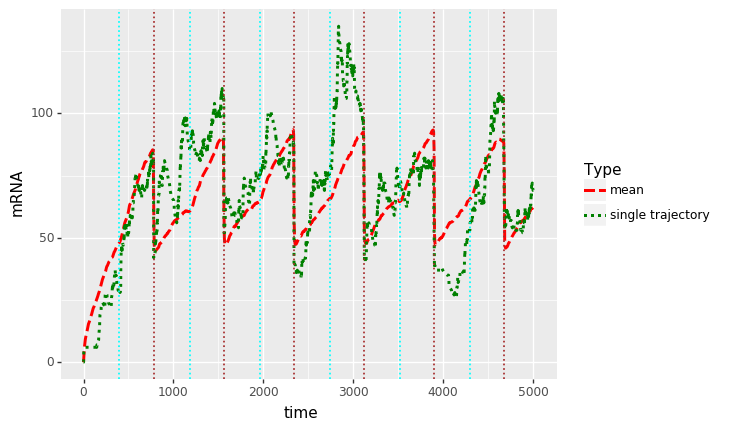

<ggplot: (8769580441569)>


In [29]:
i = 87
j = 1
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (xnew).tolist(), \
       'mRNA': results[i][2] + \
       (ynew).tolist(), 
       'Type': (['single trajectory'] * len(results[i][0])) + (['mean'] * len(ynew))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line(aes(linetype='Type', color='Type'), size = 1.2) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
time_cur = tr
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "cyan", size = 0.7)
    time_cur += td
time_cur = td
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "brown", size = 0.7)
    time_cur += td
    
print(p)

In [518]:
xnew = np.linspace(0, 5000, num=1000, endpoint=True)
ynew = np.zeros((1000))
for _ in range(nrepeats):
    x = np.cumsum(results[_][0])
    y = results[_][1]
    func_ = interp1d(x, y, kind='linear')
    ynew += func_(xnew)
ynew /= nrepeats

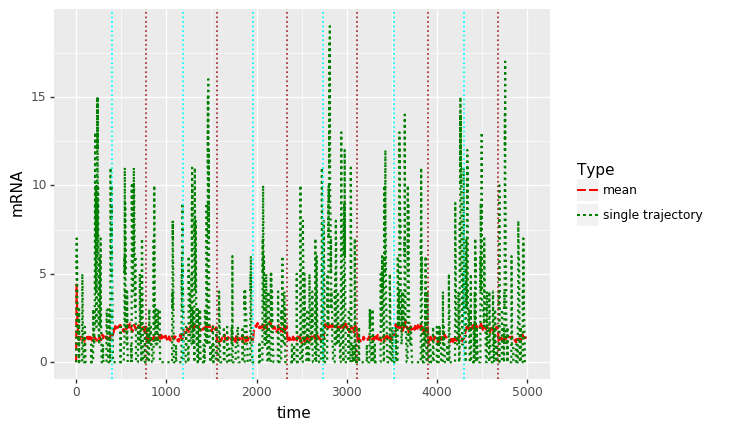

<ggplot: (-9223363289992629970)>


In [520]:
i = 49
j = 1
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (xnew).tolist(), \
       'mRNA': results[i][1] + \
       (ynew).tolist(), 
       'Type': (['single trajectory'] * len(results[i][0])) + (['mean'] * len(ynew))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line(aes(linetype='Type', color='Type'), size = 0.9) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
time_cur = tr
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "cyan", size = 0.7)
    time_cur += td
time_cur = td
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "brown", size = 0.7)
    time_cur += td
    
print(p)

In [483]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = sum(results[_][0])
min_time_steps = np.min(num_time_steps)
print(min_time_steps)


5000.129720731175


In [470]:
nrepeats = 100
num_time_steps = np.zeros((nrepeats))
for _ in range(nrepeats):
    num_time_steps[_] = np.cumsum(results[_][0])
min_time_steps = np.min(num_time_steps)
print(min_time_steps)

mean_over_time, var_over_time = np.zeros((2, int(min_time_steps))), np.zeros((2, int(min_time_steps)))
for _ in range(int(min_time_steps)):
#     print(_)
    mRNA_t = np.zeros((nrepeats))
    for i in range(nrepeats):
#         print(i)
        mRNA_t[i] = results[i][1][_]
    mean_over_time[0, _] = np.mean(mRNA_t)
    var_over_time[0, _] = np.var(mRNA_t)
    
    for i in range(nrepeats):
        mRNA_t[i] = results[i][1][_]
    mean_over_time[1, _] = np.mean(mRNA_t)
    var_over_time[1, _] = np.var(mRNA_t)

3233.0


In [471]:
print(len(results[0][0][0:int(min_time_steps)]))

3233


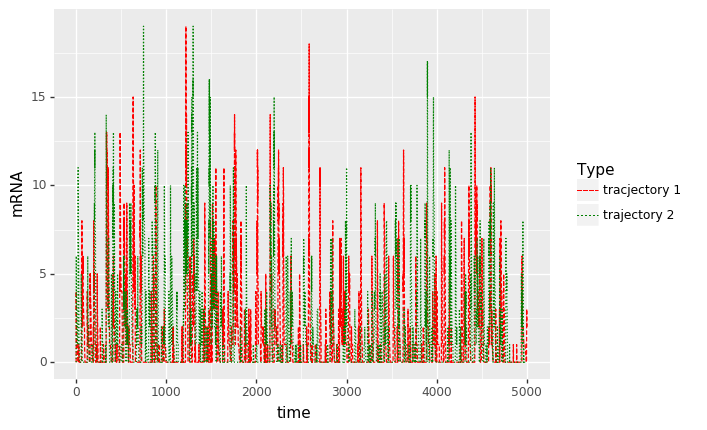

<ggplot: (8746853672957)>


In [477]:
i = 77
j = 1
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (np.cumsum(results[j][0])).tolist(), \
       'mRNA': results[i][1] + \
       results[j][1], 
       'Type': (['tracjectory 1'] * len(results[i][1])) + (['trajectory 2'] * len(results[j][1]))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line(aes(linetype='Type', color='Type')) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
print(p)

In [ ]:
i = 87
j = 18
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (np.cumsum(results[j][0])).tolist(), \
       'mRNA': results[i][1] + \
       results[j][1], 
       'Type': (['tracjectory 1'] * len(results[i][1])) + (['trajectory 2'] * len(results[j][1]))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line(aes(linetype='Type', color='Type')) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
print(p)

In [419]:
# print(two_state.backward_rxn_list)
two_state.calculate_propensity(molecule_count)
print(*(two_state.rxn_rates))

0.0282 0.609 2.11 0.1299 0.00245


In [420]:
time_ = 5000
molecule_count = [[1], [0], [1], [0], [0], [1], [0], [1], [0], [0]]
two_state.simulate(time_, molecule_count)

[0.0282, 0.609, 2.11, 0.1299, 0.00245]


In [421]:
print(two_state.rxn_rates)

[0.0282, 0.609, 2.11, 0.1299, 0.00245]


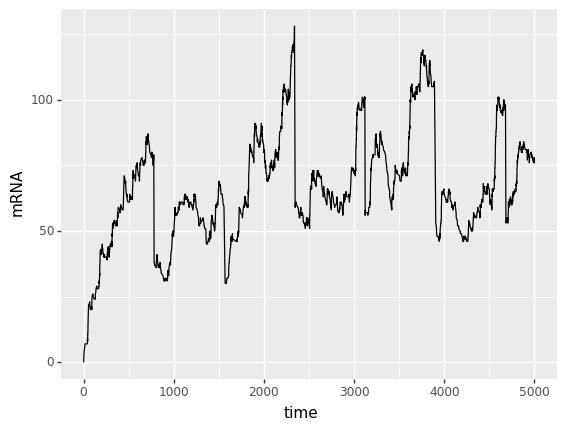

<ggplot: (8746861986694)>


In [452]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[9]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [ ]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[9]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [247]:
np.random.randint(0, 2)

0

In [373]:
class test_:
    def __init__(self, val1, val2):
        self.val1 = val1
        self.val2 = val2
    def test_method(self):
        self.val1 = self.val2 * 0.2

In [374]:
tmp = test_(2, 3)

In [376]:
tmp.test_method()
print(tmp.val2)

3
